In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import export_graphviz

from yellowbrick.features import (FeatureImportances,)
#  conda install -c districtdatalabs yellowbrick 

import sys
sys.path.append('../')  # getting to below function

from df_cleaning import df_cleaning  # data celaning function

c:\Users\Dell\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv("../data/insurance.csv")

In [3]:
df = df_cleaning(df)
df.head(5)

1. All duplicated rows within dataset will be dropped. Found: 1 duplicated rows.
2. All missing values within dataset will be replaced with 0. Found: 0 missing values. 


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,charges
0,19,27.900,0,0,1,0,0,1,16884.92400
1,18,33.770,1,1,0,0,1,0,1725.55230
2,28,33.000,3,1,0,0,1,0,4449.46200
3,33,22.705,0,1,0,1,0,0,21984.47061
4,32,28.880,0,1,0,1,0,0,3866.85520


In [4]:
X = df.drop('charges', axis = 1)
y = df['charges']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [6]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 238, random_seed=42, n_jobs=4, learning_rate=0.225, gamma=0.6, max_depth=3, subsample=0.8378537709017343, colsample_bytree=0.85)

In [7]:
# Fitting the model
xgb_r.fit(X_train, y_train, early_stopping_rounds=10, 
             eval_set=[(X_test, y_test)], 
             verbose=False)

[23:05:30] WARNING: ..\src\learner.cc:576: 
Parameters: { "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




c:\Users\Dell\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.85,
             enable_categorical=False, gamma=0.6, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.225, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=238, n_jobs=4, num_parallel_tree=1, predictor='auto',
             random_seed=42, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.8378537709017343,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
# load data in do training
param = {'max_depth':6, 'eta':0.3, 'objective':'reg:squarederror'}
num_round = 200
dtrain = xg.DMatrix(data=X, label=y)
print('running cross validation')
# do cross validation, this will print result out as
# [iteration]  metric_name:mean_value+std_value
# std_value is standard deviation of the metric
xg_cv = xg.cv(param, dtrain, num_round, nfold=5,
       metrics={'rmse'}, seed=0,
       callbacks=[xg.callback.EvaluationMonitor(show_stdv=True)])

# xgb.cv(
#   params = params,
#   dtrain = dtrain_matrix,
#   num_boost_round=1000,  # Maximum iterations
#   nfold=5, # Number of folds to use
#   metrics = 'rmse', # List of evaluation metrics to be used in cross validation, when it is not specified, the evaluation metric is chosen according to objective function.
#   as_pandas = True,
#   seed = 42,
#   early_stopping_rounds = 10, # Training with a validation set will stop if the performance doesn't improve for n rounds.

# print('running cross validation, disable standard deviation display')
# # do cross validation, this will print result out as
# # [iteration]  metric_name:mean_value
# res = xg.cv(param, dtrain, num_boost_round=100, nfold=5,
#              metrics={'rmse'}, seed=0,
#              callbacks=[xg.callback.EvaluationMonitor(show_stdv=False),
#                         xg.callback.EarlyStopping(5)])
# print(res)
# print('running cross validation, with preprocessing function')
# # define the preprocessing function
# # used to return the preprocessed training, test data, and parameter
# # we can use this to do weight rescale, etc.
# # as a example, we try to set scale_pos_weight
# def fpreproc(dtrain, dtest, param):
#     label = dtrain.get_label()
#     ratio = float(np.sum(label == 0)) / np.sum(label == 1)
#     param['scale_pos_weight'] = ratio
#     return (dtrain, dtest, param)

# # do cross validation, for each fold
# # the dtrain, dtest, param will be passed into fpreproc
# # then the return value of fpreproc will be used to generate
# # results of that fold
# xg_cv = xg.cv(param, dtrain, num_round, nfold=5,
#        metrics={'rmse'}, seed=0, fpreproc=fpreproc)

###
# you can also do cross validation with customized loss function
# See custom_objective.py
##
# print('running cross validation, with customized loss function')
# def logregobj(preds, dtrain):
#     labels = dtrain.get_label()
#     preds = 1.0 / (1.0 + np.exp(-preds))
#     grad = preds - labels
#     hess = preds * (1.0 - preds)
#     return grad, hess
# def evalerror(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'rmse', float(sum(labels != (preds > 0.0))) / len(labels)

# param = {'max_depth':2, 'eta':1}
# # train with customized objective
# xg.cv(param, dtrain, num_round, nfold=5, seed=0,
#        obj=logregobj, feval=evalerror)

running cross validation
[0]	train-rmse:13039.12480+214.58122	test-rmse:13050.49336+943.98431
[1]	train-rmse:9679.29531+154.85690	test-rmse:9761.01211+763.49576
[2]	train-rmse:7430.16494+115.03180	test-rmse:7620.85156+663.24461
[3]	train-rmse:5953.99639+89.01063	test-rmse:6297.81445+612.81569
[4]	train-rmse:5020.17080+87.09964	test-rmse:5505.29062+568.41709
[5]	train-rmse:4424.47373+97.43027	test-rmse:5066.53105+544.51885
[6]	train-rmse:4040.94541+101.10730	test-rmse:4840.75518+505.73283
[7]	train-rmse:3778.69995+122.39073	test-rmse:4722.52202+483.05636
[8]	train-rmse:3592.27612+128.10494	test-rmse:4671.24668+455.08868
[9]	train-rmse:3444.99028+129.66766	test-rmse:4676.67300+422.28793
[10]	train-rmse:3347.02593+151.62460	test-rmse:4674.88901+419.29681


c:\Users\Dell\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11]	train-rmse:3266.55825+151.41146	test-rmse:4679.47622+404.88967
[12]	train-rmse:3192.00269+155.33628	test-rmse:4691.09404+393.85184
[13]	train-rmse:3132.54233+143.94258	test-rmse:4701.40771+384.88820
[14]	train-rmse:3081.06143+124.33148	test-rmse:4700.71655+383.77951
[15]	train-rmse:2998.71089+119.05698	test-rmse:4719.28779+372.26347
[16]	train-rmse:2947.78594+128.19407	test-rmse:4724.09238+367.49904
[17]	train-rmse:2866.50127+108.13437	test-rmse:4732.93516+364.30312
[18]	train-rmse:2808.11226+87.85291	test-rmse:4749.61475+360.19830
[19]	train-rmse:2766.13843+95.85497	test-rmse:4750.61777+359.72322
[20]	train-rmse:2722.43345+124.13294	test-rmse:4747.43984+359.17918
[21]	train-rmse:2682.08262+124.89504	test-rmse:4760.11465+348.05884
[22]	train-rmse:2625.80566+111.74014	test-rmse:4777.98535+349.14789
[23]	train-rmse:2587.02104+107.84127	test-rmse:4791.05146+350.41180
[24]	train-rmse:2543.52593+95.50512	test-rmse:4803.38008+351.39627
[25]	train-rmse:2521.32026+96.33684	test-rmse:4812.

Text(0.5, 0, 'Round')

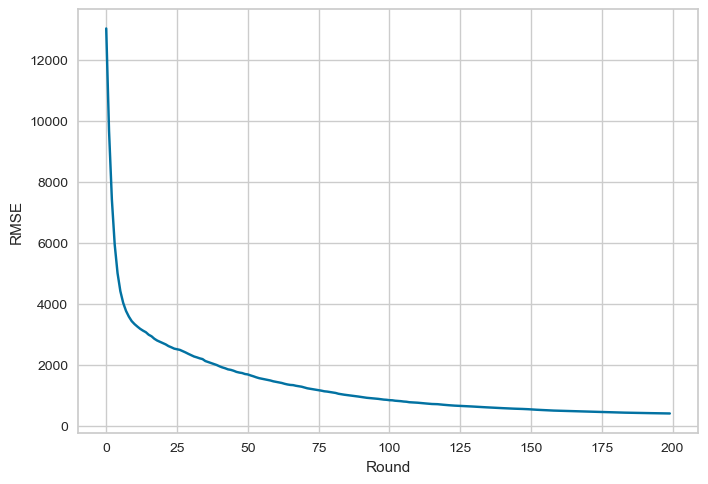

In [34]:
plt.plot(xg_cv.iloc[:,0])
plt.ylabel("RMSE")
plt.xlabel('Round')

In [9]:
# Predict the model
y_pred = xgb_r.predict(X_test)

In [10]:
y_pred == y_test

1248    False
610     False
393     False
503     False
198     False
        ...  
885     False
422     False
294     False
261     False
611     False
Name: charges, Length: 442, dtype: bool

In [11]:
# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_pred))
print("RMSE : % f" %(rmse))

RMSE :  4717.060737


In [12]:
for col, val in sorted(
    zip(
        X.columns, xgb_r.feature_importances_
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

smoker_yes     0.852
age            0.052
bmi            0.051
region_northwest     0.013
children       0.012


[Text(0.5, 1.0, 'Wykres ważności cech'),
 Text(0.5, 0, 'Ocena F'),
 Text(0, 0.5, 'Cecha')]

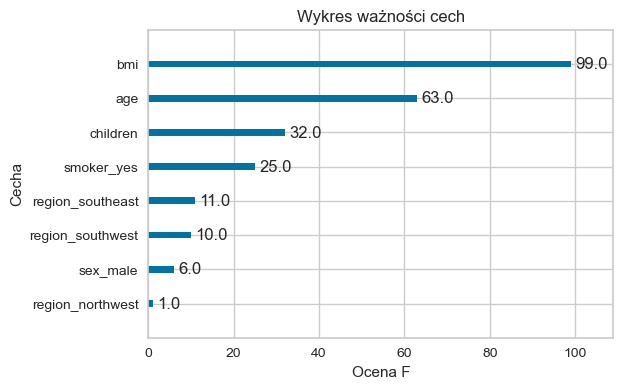

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
xg.plot_importance(xgb_r, ax=ax)
ax.set(title="Wykres ważności cech", xlabel="Ocena F", ylabel="Cecha")
#fig.savefig("images/mlpr_1405.png", dpi=300)

FeatureImportances(ax=<AxesSubplot: title={'center': 'Wykres względnych ważności cech'}, xlabel='Względna ważność cechy', ylabel='Cecha'>,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.85,
                                          enable_categorical=False, gamma=0.6,
                                          gpu_id=-1, importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.225, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=238, n_jobs=4,
                     

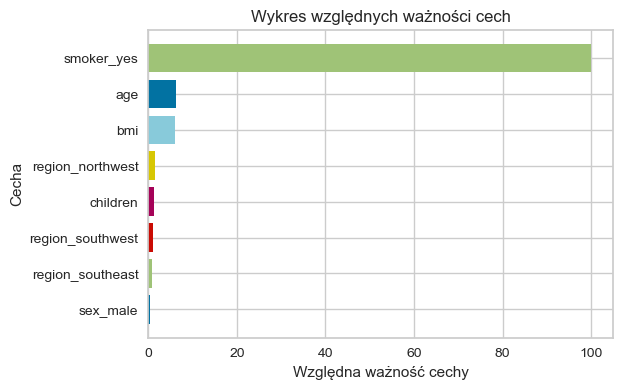

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set(title="Wykres względnych ważności cech", xlabel="Względna ważność cechy", ylabel="Cecha")
fi_viz = FeatureImportances(xgb_r)
fi_viz.fit(X_train, y_train)
#fig.savefig("images/mlpr_1406.png", dpi=300)

In [15]:
booster = xgb_r.get_booster()
print(booster.get_dump()[0])

0:[smoker_yes<1] yes=1,no=2,missing=1
	1:[bmi<23.9399986] yes=3,no=4,missing=3
		3:[region_southwest<1] yes=7,no=8,missing=7
			7:leaf=1505.59888
			8:leaf=950.580261
		4:[children<2] yes=9,no=10,missing=9
			9:leaf=1819.06506
			10:leaf=2249.54858
	2:[bmi<30.1000004] yes=5,no=6,missing=5
		5:[bmi<17.5275002] yes=11,no=12,missing=11
			11:leaf=1443.25745
			12:leaf=4971.74365
		6:leaf=9256.49414



In [16]:
xgb_r.get_num_boosting_rounds()

238

In [17]:
# fig, ax = plt.subplots(figsize=(24, 16))
# xg.plot_tree(xgb_r, ax=ax, num_trees=0)
# # fig.savefig('images/mlpr_1407.png', dpi=300)